# Flower Recognition CNN Keras

In [45]:
import os
print(os.listdir(r'C:\Users\User\Downloads\flowers'))

['daisy', 'dandelion', 'flowers', 'rose', 'sunflower', 'tulip']


In [93]:
species=['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']

## CONTENTS ::

<a id="content1"></a>
## 1 ) Importing Various Modules.

In [46]:

import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
 

%matplotlib inline  
style.use('fivethirtyeight')
sns.set(style='whitegrid',color_codes=True)


from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score,precision_score,recall_score,confusion_matrix,roc_curve,roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder


from keras.preprocessing.image import ImageDataGenerator


from keras import backend as K
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam,SGD,Adagrad,Adadelta,RMSprop
from keras.utils import to_categorical


from keras.layers import Dropout, Flatten,Activation
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
 
import tensorflow as tf
import random as rn


import cv2                  
import numpy as np  
from tqdm import tqdm
import os                   
from random import shuffle  
from zipfile import ZipFile
from PIL import Image

<a id="content2"></a>
## 2 ) Preparing the Data

## 2.1) Making the functions to get the training and validation set from the Images

In [47]:
X=[]
Z=[]
IMG_SIZE=150
FLOWER_DAISY_DIR=r'C:\Users\User\Downloads\flowers\daisy'
FLOWER_SUNFLOWER_DIR=r'C:\Users\User\Downloads\flowers\sunflower'
FLOWER_TULIP_DIR=r'C:\Users\User\Downloads\flowers\tulip'
FLOWER_DANDI_DIR=r'C:\Users\User\Downloads\flowers\dandelion'
FLOWER_ROSE_DIR=r'C:\Users\User\Downloads\flowers\rose'


In [48]:
def assign_label(img,flower_type):
    return flower_type
    

In [49]:
def make_train_data(flower_type,DIR):
    for img in tqdm(os.listdir(DIR)):
        label=assign_label(img,flower_type)
        path = os.path.join(DIR,img)
        img = cv2.imread(path,cv2.IMREAD_COLOR)
        img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))
        
        X.append(np.array(img))
        Z.append(str(label))
        
        
        

In [50]:
make_train_data('Daisy',FLOWER_DAISY_DIR)
print(len(X))

100%|███████████████████████████████████████████████████████████████████████████████| 769/769 [00:07<00:00, 107.96it/s]

769


In [51]:
make_train_data('Sunflower',FLOWER_SUNFLOWER_DIR)
print(len(X))

100%|███████████████████████████████████████████████████████████████████████████████| 734/734 [00:03<00:00, 202.11it/s]

1503


In [52]:
make_train_data('Tulip',FLOWER_TULIP_DIR)
print(len(X))

100%|███████████████████████████████████████████████████████████████████████████████| 984/984 [00:03<00:00, 281.35it/s]

2487


In [54]:
make_train_data('Dandelion',FLOWER_DANDI_DIR)
print(len(X))

100%|████████████████████████████████████████████████████████████████████████████▊| 1052/1055 [00:06<00:00, 154.25it/s]


error: OpenCV(4.4.0) C:\Users\appveyor\AppData\Local\Temp\1\pip-req-build-h4wtvo23\opencv\modules\imgproc\src\resize.cpp:3929: error: (-215:Assertion failed) !ssize.empty() in function 'cv::resize'


In [53]:
make_train_data('Rose',FLOWER_ROSE_DIR)
print(len(X))

100%|███████████████████████████████████████████████████████████████████████████████| 784/784 [00:03<00:00, 216.35it/s]

3271


## 2.2 ) Visualizing some Random Images

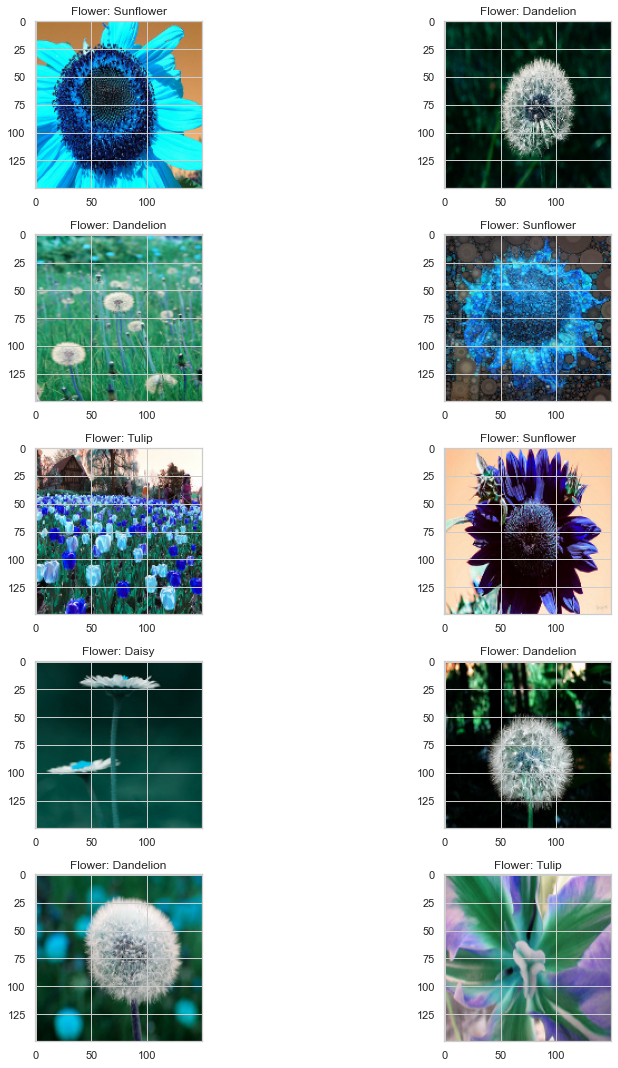

In [55]:
fig,ax=plt.subplots(5,2)
fig.set_size_inches(15,15)
for i in range(5):
    for j in range (2):
        l=rn.randint(0,len(Z))
        ax[i,j].imshow(X[l])
        ax[i,j].set_title('Flower: '+Z[l])
        
plt.tight_layout()
        

## 2.3 ) Label Encoding the Y array (i.e. Daisy->0, Rose->1 etc...) & then One Hot Encoding

In [56]:
le=LabelEncoder()
Y=le.fit_transform(Z)
Y=to_categorical(Y,5)
X=np.array(X)
X=X/255

## 2.4 ) Splitting into Training and Validation Sets

In [57]:
x_train,x_test,y_train,y_test=train_test_split(X,Y,test_size=0.25,random_state=42)


## 2.5 ) Setting the Random Seeds

In [59]:
np.random.seed(42)
rn.seed(42)


<a id="content3"></a>
## 3 ) Modelling

## 3.1 ) Building the ConvNet Model

In [60]:
# # modelling starts using a CNN.

model = Sequential()
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same',activation ='relu', input_shape = (150,150,3)))
model.add(MaxPooling2D(pool_size=(2,2)))


model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same',activation ='relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
 

model.add(Conv2D(filters =96, kernel_size = (3,3),padding = 'Same',activation ='relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

model.add(Conv2D(filters = 96, kernel_size = (3,3),padding = 'Same',activation ='relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dense(5, activation = "softmax"))

## 3.2 ) Using a LR Annealer

In [61]:
batch_size=128
epochs=50

from keras.callbacks import ReduceLROnPlateau
red_lr= ReduceLROnPlateau(monitor='val_acc',patience=3,verbose=1,factor=0.1)

## 3.3 ) Data Augmentation to prevent Overfitting

In [62]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.2,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.2,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(x_train)

## 3.4 ) Compiling the Keras Model & Summary

In [63]:
model.compile(optimizer=Adam(lr=0.001),loss='categorical_crossentropy',metrics=['accuracy'])

In [64]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 150, 150, 32)      2432      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 75, 75, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 75, 75, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 37, 37, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 37, 37, 96)        55392     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 18, 18, 96)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 18, 18, 96)        8

## 3.5 ) Fitting on the Training set and making predcitons on the Validation set

In [65]:
History = model.fit_generator(datagen.flow(x_train,y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (x_test,y_test),
                              verbose = 1, steps_per_epoch=x_train.shape[0] // batch_size)
# model.fit(x_train,y_train,epochs=epochs,batch_size=batch_size,validation_data = (x_test,y_test))

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/50
25/25 [==============================] - 117s 5s/step - loss: 1.4214 - accuracy: 0.3484 - val_loss: 1.2501 - val_accuracy: 0.4422
Epoch 2/50
25/25 [==============================] - 116s 5s/step - loss: 1.1846 - accuracy: 0.5093 - val_loss: 1.1451 - val_accuracy: 0.5171
Epoch 3/50
25/25 [==============================] - 109s 4s/step - loss: 1.0929 - accuracy: 0.5572 - val_loss: 1.0318 - val_accuracy: 0.5837
Epoch 4/50
25/25 [==============================] - 108s 4s/step - loss: 1.0132 - accuracy: 0.6024 - val_loss: 0.9003 - val_accuracy: 0.6531
Epoch 5/50
25/25 [==============================] - 110s 4s/step - loss: 0.9303 - accuracy: 0.6249 - val_loss: 0.9444 - val_accuracy: 0.6272
Epoch 6/50
25/25 [==============================] - 110s 4s/step - loss: 0.8983 - accuracy: 0.6532 - val_loss: 0.9720 - val_accuracy: 0.6142
Epoch 7/50
25/25 [==============================] - 109s 4s/step - loss: 0.879

<a id="content4"></a>
## 4 ) Evaluating the Model Performance

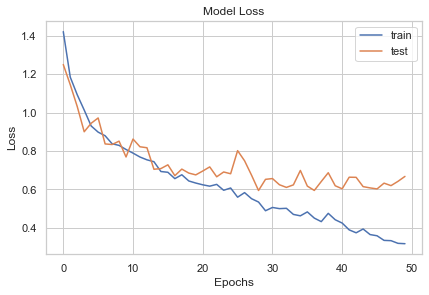

In [66]:
plt.plot(History.history['loss'])
plt.plot(History.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.show()

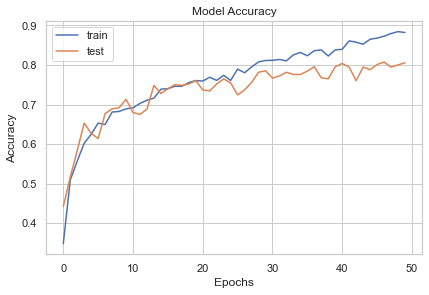

In [69]:
plt.plot(History.history['accuracy'])
plt.plot(History.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.show()


<a id="content5"></a>
## 5 ) Visualizing Predictons 

### Predicting a random image

In [83]:
img1 = Image.open(r'C:\Users\User\Desktop\predictit.jpg')
imResize = img1.resize((150,150), Image.ANTIALIAS)
imResize.save('predictit.jpg', 'JPEG', quality=90)


(1, 150, 150, 3)

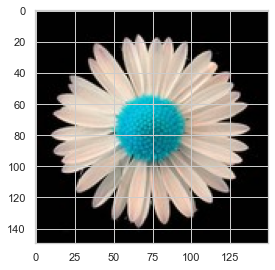

In [85]:
predictimg=cv2.imread("predictit.jpg",1)
predictimg=np.array(predictimg)
plt.imshow(predictimg)
predictimg=predictimg/255.0

predictimg = np.expand_dims(predictimg, axis=0)
predictimg.shape

In [88]:
predition=model.predict(predictimg)

predition=np.squeeze(predition)
print(predition)
predIndex=np.argmax(predition)

[9.9999988e-01 6.9980970e-08 3.5212439e-10 4.2580041e-12 7.7365225e-10]


In [92]:
print("The Species of given image is",species[predIndex])

The Species of given image is daisy


# THE END